In [ ]:
%pip install xgboost

In [ ]:
%pip install hyperopt

In [3]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [4]:
import pandas as pd

In [5]:
import pickle

In [25]:
%pip install python-dotenv


  Using cached python_dotenv-1.0.0-py3-none-any.whl (19 kB)


In [4]:
from dotenv import load_dotenv
load_dotenv(verbose=True)

True

In [6]:
import os
mlflow_database_url = os.environ["MLFLOW_DATABASE_URL"]

In [ ]:
%pip install mlflow

In [38]:
%pip install numpy

In [7]:
import mlflow

In [ ]:
%pip install psycopg2

In [8]:
mlflow.set_tracking_uri(mlflow_database_url)
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='file:///g:/RGT-PROJECTS/MLOps-project/mlruns/1', creation_time=1702295813346, experiment_id='1', last_update_time=1702295813346, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

In [11]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [18]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [19]:
df['duration'].head()

0    3.933333
1    8.750000
2    5.966667
3    7.083333
4    0.066667
Name: duration, dtype: float64

In [20]:
df['duration'].isnull().sum()

0

In [14]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73908 entries, 0 to 76517
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               73908 non-null  int64         
 1   lpep_pickup_datetime   73908 non-null  datetime64[us]
 2   lpep_dropoff_datetime  73908 non-null  datetime64[us]
 3   store_and_fwd_flag     38175 non-null  object        
 4   RatecodeID             38175 non-null  float64       
 5   PULocationID           73908 non-null  object        
 6   DOLocationID           73908 non-null  object        
 7   passenger_count        38175 non-null  float64       
 8   trip_distance          73908 non-null  float64       
 9   fare_amount            73908 non-null  float64       
 10  extra                  73908 non-null  float64       
 11  mta_tax                73908 non-null  float64       
 12  tip_amount             73908 non-null  float64       
 13  tolls_

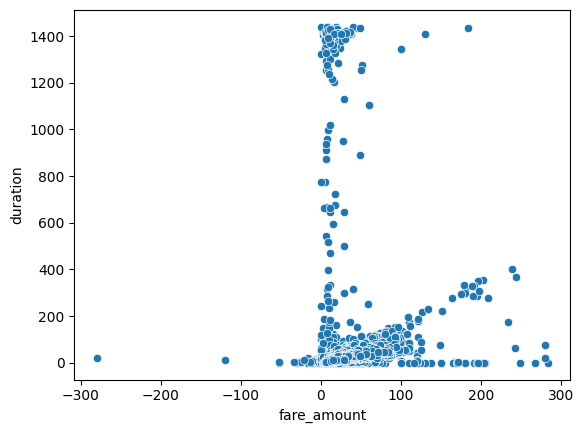

In [21]:
sns.scatterplot(data=df,x='fare_amount',y='duration')
plt.show()

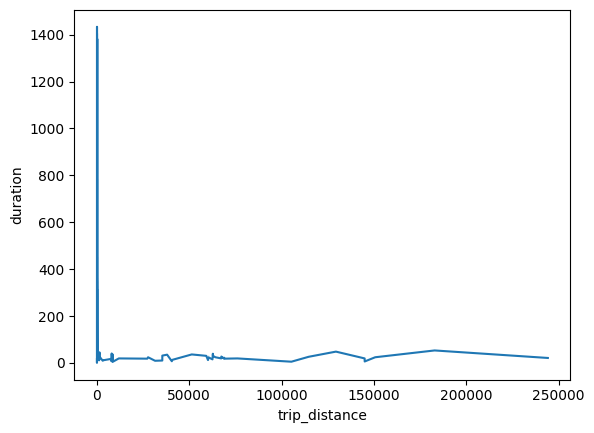

In [24]:
sns.lineplot(data=df,x='trip_distance',y='duration')
plt.show()

In [27]:
df['extra'].value_counts()

extra
 0.00    47616
 2.75    14551
 1.00     7433
 0.50     5229
 5.50      693
 3.75      397
 3.25      261
 1.35      260
 4.09       24
-0.50       21
-1.00       21
 4.50        6
-2.75        3
 8.25        2
-5.50        1
Name: count, dtype: int64

<Axes: xlabel='extra', ylabel='duration'>

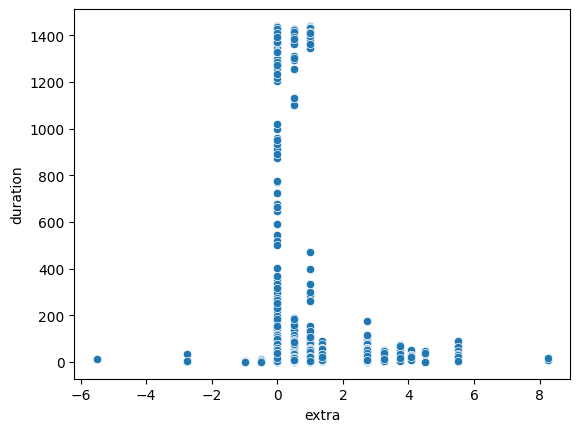

In [36]:
sns.scatterplot(data=df,x='extra',y='duration')

In [33]:
df['mta_tax'].value_counts()

mta_tax
 0.5    39002
 0.0    37401
-0.5      115
Name: count, dtype: int64

<Axes: xlabel='mta_tax', ylabel='duration'>

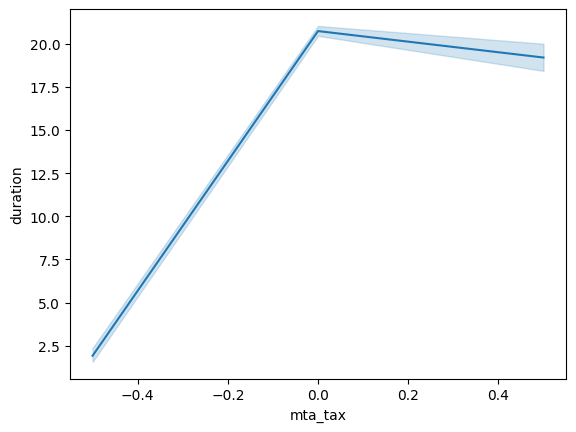

In [41]:
sns.lineplot(data=df,x='mta_tax',y='duration')

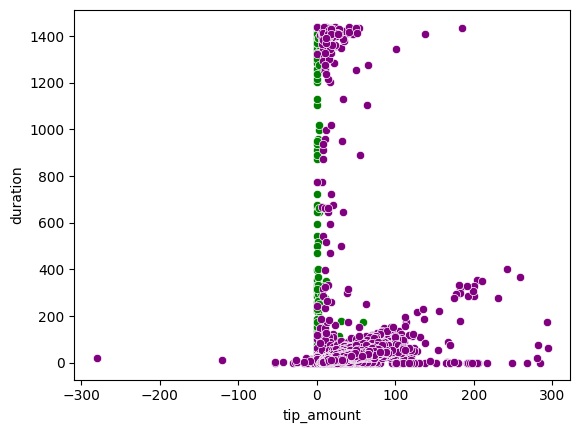

In [42]:
sns.scatterplot(data=df,x='tip_amount',y='duration',c='green')
sns.scatterplot(data=df,x='total_amount',y='duration',c='purple')
plt.show()

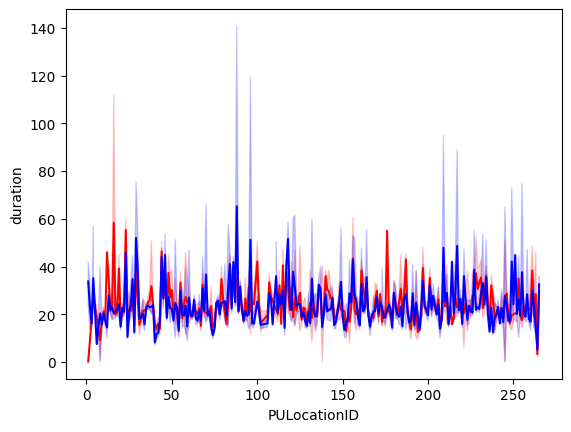

In [46]:
sns.lineplot(data=df,x='PULocationID',y='duration',color='red')
sns.lineplot(data=df,x='DOLocationID',y='duration',color='blue')
plt.show()

In [16]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829628

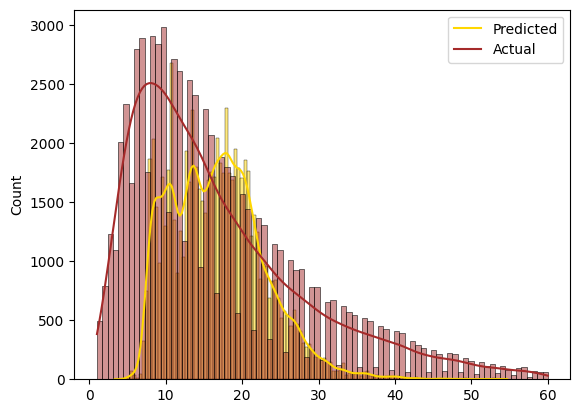

In [17]:
sns.histplot(y_pred, kde=True, color='gold', fill=True)
sns.histplot(y_train, kde=True, color='brown', fill=True)

plt.legend(['Predicted','Actual'])
plt.show()

In [18]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [19]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [20]:
len(df_train), len(df_val)

(73908, 61921)

In [21]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [22]:
categorical = ['PU_DO'] 
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [23]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715200888857

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [25]:
with mlflow.start_run():
    mlflow.set_tag("developer","Emmanuel")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    
    alpha= 0.01
    mlflow.log_param("alpha",alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="mlrun/models")

In [26]:
train = xgb.DMatrix(X_train,label=y_train)
valid = xgb.DMatrix(X_val,label=y_val)

In [27]:
#define objective function
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=10,
            evals=[(valid,"validation")],
            early_stopping_rounds=5
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val,y_pred,squared=False)
        mlflow.log_metric("rmse",rmse)
    return {'loss' : rmse, 'status':STATUS_OK}    

In [27]:
#Define the search space 
#specify the hyper parameters
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate': hp.loguniform('learning_rate',-3,0),
    'reg_alpha':hp.loguniform('reg_alpha',-5,-1),
    'min_child_weight':hp.loguniform('min_child_weight',-1,3),
    'objective':'reg:linear',
    'seed':42,
}


best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.29290                           
[1]	validation-rmse:6.69978                           
[2]	validation-rmse:6.60185                           
[3]	validation-rmse:6.57662                           
[4]	validation-rmse:6.56208                           
[5]	validation-rmse:6.55587                           
[6]	validation-rmse:6.54578                           
[7]	validation-rmse:6.53836                           
[8]	validation-rmse:6.53383                           
[9]	validation-rmse:6.52738                           
 10%|█         | 1/10 [00:55<08:22, 55.81s/trial, best loss: 6.527378203221418]

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.31762                                                   
[1]	validation-rmse:10.54898                                                   
[2]	validation-rmse:9.89304                                                    
[3]	validation-rmse:9.33624                                                    
[4]	validation-rmse:8.86548                                                    
[5]	validation-rmse:8.46999                                                    
[6]	validation-rmse:8.13720                                                    
[7]	validation-rmse:7.86238                                                    
[8]	validation-rmse:7.63165                                                    
[9]	validation-rmse:7.43941                                                    
 20%|██        | 2/10 [04:27<19:40, 147.57s/trial, best loss: 6.527378203221418]

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:29:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.59418                                                     
[1]	validation-rmse:7.34291                                                     
[2]	validation-rmse:6.94348                                                     
[3]	validation-rmse:6.80755                                                     
[4]	validation-rmse:6.75311                                                     
[5]	validation-rmse:6.72913                                                     
[6]	validation-rmse:6.71557                                                     
[7]	validation-rmse:6.71115                                                     
[8]	validation-rmse:6.70595                                                     
[9]	validation-rmse:6.70133                                                     
 30%|███       | 3/10 [04:33<09:40, 82.90s/trial, best loss: 6.527378203221418] 

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.87021                                                    
[1]	validation-rmse:8.46403                                                    
[2]	validation-rmse:7.66207                                                    
[3]	validation-rmse:7.21183                                                    
[4]	validation-rmse:6.96119                                                    
[5]	validation-rmse:6.81748                                                    
[6]	validation-rmse:6.73171                                                    
[7]	validation-rmse:6.67858                                                    
[8]	validation-rmse:6.64515                                                    
[9]	validation-rmse:6.62374                                                    
 40%|████      | 4/10 [04:49<05:39, 56.53s/trial, best loss: 6.527378203221418]

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86264                                                    
[1]	validation-rmse:7.47485                                                    
[2]	validation-rmse:6.94386                                                    
[3]	validation-rmse:6.73231                                                    
[4]	validation-rmse:6.63467                                                    
[5]	validation-rmse:6.58636                                                    
[6]	validation-rmse:6.56268                                                    
[7]	validation-rmse:6.54622                                                    
[8]	validation-rmse:6.53753                                                    
[9]	validation-rmse:6.53319                                                    
 50%|█████     | 5/10 [05:32<04:17, 51.54s/trial, best loss: 6.527378203221418]

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.11742                                                    
[1]	validation-rmse:7.67723                                                    
[2]	validation-rmse:7.04105                                                    
[3]	validation-rmse:6.76692                                                    
[4]	validation-rmse:6.63820                                                    
[5]	validation-rmse:6.57233                                                    
[6]	validation-rmse:6.53168                                                    
[7]	validation-rmse:6.51010                                                    
[8]	validation-rmse:6.49736                                                    
[9]	validation-rmse:6.48657                                                    
 60%|██████    | 6/10 [06:50<04:02, 60.74s/trial, best loss: 6.486570694980594]

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.69615                                                   
[1]	validation-rmse:9.55606                                                    
[2]	validation-rmse:8.71481                                                    
[3]	validation-rmse:8.10103                                                    
[4]	validation-rmse:7.65575                                                    
[5]	validation-rmse:7.33727                                                    
[6]	validation-rmse:7.11160                                                    
[7]	validation-rmse:6.95217                                                    
[8]	validation-rmse:6.83518                                                    
[9]	validation-rmse:6.75153                                                    
 70%|███████   | 7/10 [09:24<04:33, 91.10s/trial, best loss: 6.486570694980594]

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.24066                                                   
[1]	validation-rmse:10.41804                                                   
[2]	validation-rmse:9.72670                                                    
[3]	validation-rmse:9.15027                                                    
[4]	validation-rmse:8.67084                                                    
[5]	validation-rmse:8.27388                                                    
[6]	validation-rmse:7.94945                                                    
[7]	validation-rmse:7.68238                                                    
[8]	validation-rmse:7.46468                                                    
[9]	validation-rmse:7.28639                                                    
 80%|████████  | 8/10 [11:54<03:39, 109.66s/trial, best loss: 6.486570694980594]

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.21165                                                    
[1]	validation-rmse:10.37095                                                    
[2]	validation-rmse:9.66972                                                     
[3]	validation-rmse:9.09027                                                     
[4]	validation-rmse:8.61315                                                     
[5]	validation-rmse:8.21899                                                     
[6]	validation-rmse:7.90171                                                     
[7]	validation-rmse:7.64251                                                     
[8]	validation-rmse:7.43634                                                     
[9]	validation-rmse:7.26665                                                     
 90%|█████████ | 9/10 [13:03<01:37, 97.08s/trial, best loss: 6.486570694980594] 

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54186                                                   
[1]	validation-rmse:10.94254                                                   
[2]	validation-rmse:10.40874                                                   
[3]	validation-rmse:9.93474                                                    
[4]	validation-rmse:9.51544                                                    
[5]	validation-rmse:9.14449                                                    
[6]	validation-rmse:8.81753                                                    
[7]	validation-rmse:8.52984                                                    
[8]	validation-rmse:8.27790                                                    
[9]	validation-rmse:8.05741                                                    
100%|██████████| 10/10 [14:40<00:00, 88.06s/trial, best loss: 6.486570694980594]


In [30]:
mlflow.xgboost.autolog(disable=True)

In [31]:
with mlflow.start_run():
    
    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }
    
    mlflow.log_params(best_params)
    
    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=10,
        evals=[(valid, 'validation')],
        early_stopping_rounds=5
    ) 
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val,y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv,f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="mlruns/models")
    
    mlflow.xgboost.log_model(booster, artifact_path="mlruns/models")

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709


g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\_distutils_hack

In [32]:
logged_model = 'runs:/47b0caad744f42e287ca780f6020faa9/mlruns/models'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [33]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: mlruns/models
  flavor: mlflow.xgboost
  run_id: 47b0caad744f42e287ca780f6020faa9

In [34]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [35]:
xgboost_model

In [36]:
y_pred = xgboost_model.predict(valid)

In [37]:
y_pred[:10]

array([16.960583, 10.699288, 19.122972, 21.672714, 12.3463  , 17.021257,
       15.031819, 12.508001, 11.855707, 18.193722], dtype=float32)